In [83]:
import pandas as pd
import numpy as np
import random
import json

In [84]:
district_list = np.arange(1,12)
district_df = []

In [85]:
guide_list = ['alice', 'guardian', 'league & broke', 'berniecrats', 'chronicle', 'examiner']


voter_guide_data = pd.DataFrame({
    'alice': {'sup_1': '0000180', 'sup_2': '0000179', 'sup_3': '0000000'},
    'guardian': {'sup_1': '0000181', 'sup_2': '0000180', 'sup_3': '0000000'},
    'league & broke': {'sup_1': '0000181', 'sup_2': '0000180', 'sup_3': '0000184'},
    'berniecrats': {'sup_1': '0000181', 'sup_2': '0000184', 'sup_3': '0000180'},
    'chronicle': {'sup_1': '0000179', 'sup_2': '0000000', 'sup_3': '0000000'},
    'examiner': {'sup_1': '0000180', 'sup_2': '0000000', 'sup_3': '0000000'}
}).T

candidate_list = list(set(voter_guide_data.values.flatten().tolist()))
candidate_list.remove('0000000')
print(candidate_list)


['0000181', '0000179', '0000184', '0000180']


In [86]:
precinct_id_to_name = pd.read_csv('./precinct_id_to_name.txt', sep="\t")

t1 = precinct_id_to_name.loc[:, ['precinct_id', 'name']]
t1.rename(columns={'name': 'precinct_name'}, inplace=True)
t1.precinct_name = t1.precinct_name.str[4:]
t1.precinct_name = pd.to_numeric(t1.precinct_name)


In [87]:
precinct_name_to_district = pd.read_csv('./precinct_name_to_district.txt', sep="\t")

t2 = precinct_name_to_district.loc[:, ['VotingPrecinctName', 'Supervisorial']]
t2.rename(columns={'VotingPrecinctName': 'precinct_name'}, inplace=True)
t2.precinct_name = t2.precinct_name.str[4:]
t2.precinct_name = pd.to_numeric(t2.precinct_name)

In [88]:
precinct_id_to_district = pd.merge(t1, t2, on='precinct_name', how="inner")
precinct_id_to_district.set_index('precinct_id', inplace=True)
print(precinct_id_to_district)

             precinct_name  Supervisorial
precinct_id                              
1                     1101             11
2                     1102             11
3                     1103             11
4                     1104             11
4                     1105             11
5                     1106             11
6                     1107             11
7                     1108             11
8                     1109             11
9                     1111             11
10                    1112             11
11                    1113             11
12                    1114             11
13                    1115             11
14                    1116             11
15                    1117             11
16                    1118             11
17                    1119             11
18                    1121             11
19                    1122             11
20                    1123             11
21                    1124        

In [89]:
data = pd.read_csv('./20180627_ballotimage.txt', sep=" ", header=None)
ballot = data.iloc[:, 0].astype(str)


In [90]:
input_ballot_data = pd.DataFrame({
    'contest_id': ballot.str[0:7],
    'voter_number': ballot.str[7:16],
    'serial_number': ballot.str[16:23],
    'tally_type': ballot.str[23: 26],
    'precinct_id': ballot.str[26: 33],
    'rcv': ballot.str[33: 36],
    'candidate_number': ballot.str[36: 43],
    'over': ballot.str[43],
    'under': ballot.str[44]
})

input_ballot_data['precinct_id'] = pd.to_numeric(input_ballot_data['precinct_id'])
print(input_ballot_data[input_ballot_data['under'] == '1'].head(20))
#print(input_ballot_data.head())


    contest_id voter_number serial_number tally_type  precinct_id  rcv  \
70     0000020    000012909       0000001        002            9  002   
71     0000020    000012909       0000001        002            9  003   
139    0000020    000012932       0000001        002           10  002   
140    0000020    000012932       0000001        002           10  003   
172    0000020    000012943       0000001        002           18  002   
173    0000020    000012943       0000001        002           18  003   
224    0000020    000012960       0000001        002           19  003   
256    0000020    000012971       0000001        002           19  002   
257    0000020    000012971       0000001        002           19  003   
264    0000020    000012974       0000001        002           19  001   
274    0000020    000012977       0000001        002           19  002   
275    0000020    000012977       0000001        002           19  003   
287    0000020    000012981       0000

In [91]:
ballot_data = pd.pivot_table(input_ballot_data, values='candidate_number', columns="rcv", index=["precinct_id", "serial_number"], aggfunc="first")

# Eliminate rows which have all columns as '0000000'
ballot_data = ballot_data.loc[
    ~((ballot_data['001'] == ballot_data['002']) & 
    (ballot_data['002'] == ballot_data['003']) & 
    (ballot_data['001'] == '0000000'))]



precinct_id_list = [x[0] for x in ballot_data.index.values]
precinct_id_list = set(precinct_id_list)


for x in precinct_id_list:
    ballot_data.loc[x, 'District'] = "d_" + str(precinct_id_to_district.iloc[x]['Supervisorial'])


In [92]:
for x in district_list:
    t = ballot_data[ballot_data['District'] == "d_" + str(x)]
    district_df.append(t)


In [93]:
col_list = []+ guide_list+ ['other', 'total_votes']

guide_tally = pd.DataFrame(columns=col_list)
guide_tally.index.name = 'District'

for d in district_df:
    district_name = d['District'][0]
    for index, row in voter_guide_data.iterrows():
        s = d[
          (d['001'] == row['sup_1']) & 
          ((d['002'] == row['sup_2']) | (row['sup_2'] == '0000000')) & 
          ((d['003'] == row['sup_3']) | (row['sup_3'] == '0000000'))]
        guide_tally.loc[district_name, row.name] = len(s.index)
    guide_tally.loc[district_name, 'other'] = guide_tally.loc[district_name].sum()
    guide_tally.loc[district_name, 'total_votes'] = len(d.index)
print(guide_tally)


          alice  guardian  league & broke  berniecrats  chronicle  examiner  \
District                                                                      
d_1        72.0     216.0            77.0          4.0      519.0     339.0   
d_2       101.0     170.0            50.0          4.0      864.0     442.0   
d_3        91.0     193.0            45.0          9.0      493.0     363.0   
d_4        66.0     184.0            53.0          1.0      502.0     261.0   
d_5       131.0     406.0           156.0         10.0      895.0     505.0   
d_6        95.0     158.0            49.0          6.0      555.0     382.0   
d_7       112.0     168.0            56.0          5.0      687.0     427.0   
d_8       243.0     377.0           149.0         12.0      767.0     861.0   
d_9        88.0     348.0           149.0          8.0      500.0     411.0   
d_10       59.0     143.0            42.0          3.0      768.0     272.0   
d_11       58.0     173.0            58.0          5

In [94]:
for g in guide_list:
    guide_tally[g] = guide_tally[g] / guide_tally['total_votes']
guide_tally['other'] = guide_tally['other'] / guide_tally['total_votes']
print(guide_tally)    

             alice  guardian  league & broke  berniecrats  chronicle  \
District                                                               
d_1       0.046422  0.139265        0.049645     0.002579   0.334623   
d_2       0.051557  0.086779        0.025523     0.002042   0.441041   
d_3       0.061074  0.129530        0.030201     0.006040   0.330872   
d_4       0.043053  0.120026        0.034573     0.000652   0.327462   
d_5       0.056103  0.173876        0.066809     0.004283   0.383298   
d_6       0.061528  0.102332        0.031736     0.003886   0.359456   
d_7       0.061708  0.092562        0.030854     0.002755   0.378512   
d_8       0.100082  0.155272        0.061367     0.004942   0.315898   
d_9       0.051044  0.201856        0.086427     0.004640   0.290023   
d_10      0.036510  0.088490        0.025990     0.001856   0.475248   
d_11      0.041488  0.123748        0.041488     0.003577   0.329757   

          examiner     other  total_votes  
District           

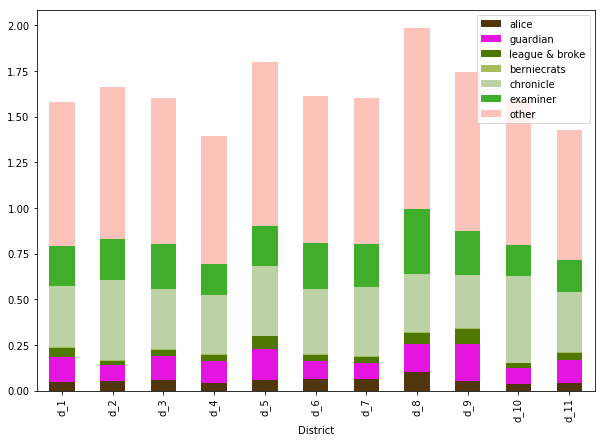

In [95]:
def generate_color_code():
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    return hex_number

colors = [""] * 7

colors = list(map(lambda x: generate_color_code(), colors))
guide_tally.loc[:, "alice": "other"].plot.bar(stacked=True, color=colors, figsize=(10,7))

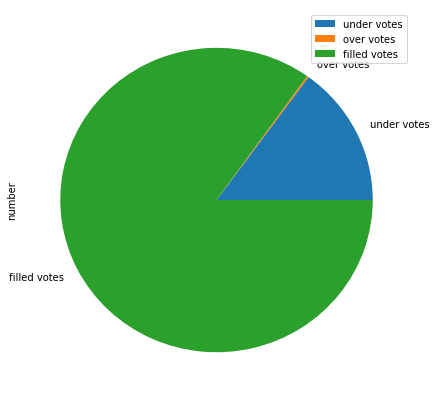

In [96]:
# Find out number of people who didn't do RCV

total_votes = len(input_ballot_data.index)
total_with_under_votes = len(input_ballot_data[input_ballot_data["under"] == "1"])
total_with_over_votes = len(input_ballot_data[input_ballot_data["over"] == "1"])


pd.DataFrame({
    'under votes': {'number': total_with_under_votes},
    'over votes': {'number': total_with_over_votes},
    'filled votes': {'number': total_votes - (total_with_over_votes  + total_with_under_votes)}
}).T.plot.pie(y="number", figsize=(7,7))




In [104]:
# Calculate bullet votes
bullet_votes_dict = {}
candidate_slot_1_dict = {}

for d in district_df:
   name = d['District'][0]
   bullet_votes_dict[name] = {}
   candidate_slot_1_dict[name] = {}

   x = d.loc[
    (d['001'] == d['002']) & 
    (d['002'] == d['003']) & 
    (d['001'] != '0000000')]

   for c_id in candidate_list:
        bullet_votes_dict[name][c_id] = len(x.loc[(x['001'] == c_id)].index)
        candidate_slot_1_dict[name][c_id] = len(d.loc[d['001'] == c_id].index)

        
print(json.dumps(candidate_slot_1_dict, indent=True))

{
 "d_1": {
  "0000181": 367,
  "0000179": 519,
  "0000184": 11,
  "0000180": 339
 },
 "d_2": {
  "0000181": 279,
  "0000179": 864,
  "0000184": 15,
  "0000180": 442
 },
 "d_3": {
  "0000181": 335,
  "0000179": 493,
  "0000184": 12,
  "0000180": 363
 },
 "d_4": {
  "0000181": 334,
  "0000179": 502,
  "0000184": 8,
  "0000180": 261
 },
 "d_5": {
  "0000181": 588,
  "0000179": 895,
  "0000184": 25,
  "0000180": 505
 },
 "d_6": {
  "0000181": 305,
  "0000179": 555,
  "0000184": 15,
  "0000180": 382
 },
 "d_7": {
  "0000181": 285,
  "0000179": 687,
  "0000184": 22,
  "0000180": 427
 },
 "d_8": {
  "0000181": 532,
  "0000179": 767,
  "0000184": 18,
  "0000180": 861
 },
 "d_9": {
  "0000181": 484,
  "0000179": 500,
  "0000184": 21,
  "0000180": 411
 },
 "d_10": {
  "0000181": 261,
  "0000179": 768,
  "0000184": 10,
  "0000180": 272
 },
 "d_11": {
  "0000181": 296,
  "0000179": 461,
  "0000184": 19,
  "0000180": 242
 }
}


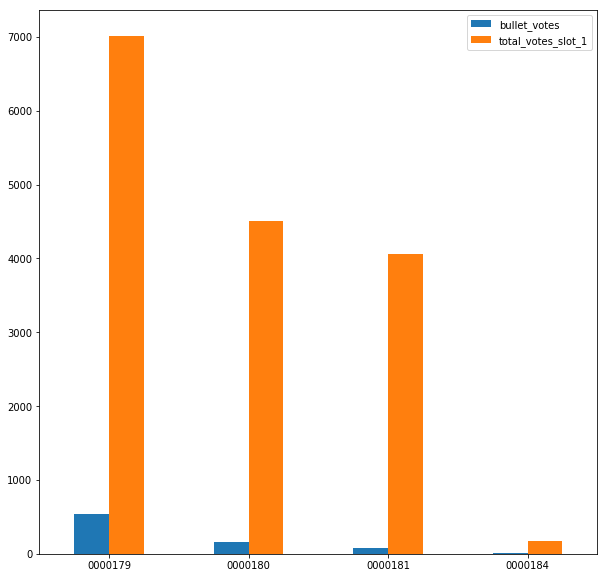

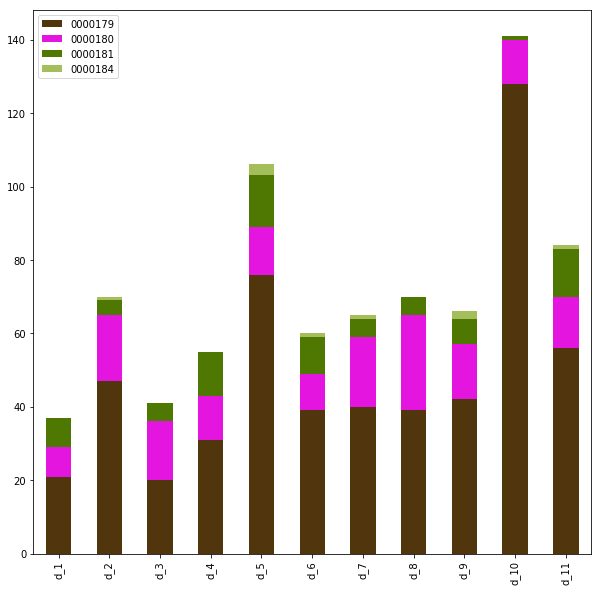

In [122]:
x = pd.DataFrame(bullet_votes_dict)
z = x.apply(sum, axis=1)

x1 = pd.DataFrame(candidate_slot_1_dict)
z1 = x1.apply(sum, axis=1)

pd.DataFrame({
    'bullet_votes': z.values,
    'total_votes_slot_1': z1.values
 }, index=z.index.to_list()).plot.bar(rot=0, figsize=(10, 10))


x.T.plot.bar(stacked=True, color=colors, figsize=(10, 10))
